In [1]:
import numpy as np
import os
import pandas as pd
import pyarrow.parquet as pq
%cd ../covid_households
import likelihood
import recipes

/Users/thayer/covid_households/covid_households


In [2]:
results = recipes.Results.load('/Users/thayer/covid_households/new_parameters/s80-p80-SAR-sizes-2-8-tweaked-dprobability')
results.find_frequencies(inplace=True)

keys = results.metadata.parameters
keys

['s80', 'p80', 'SAR']

In [10]:
# load the data as a pandas dataframe
root = "/Users/thayer/covid_households/"
empirical_df = os.path.join(root, "empirical/Ontario/empirical_df.parquet")

empirical_df = pq.read_table(empirical_df).to_pandas()

# the infections column should be integer values
empirical_df['infections'] = empirical_df['infections'].round(0)
empirical_df = empirical_df.astype({'infections': 'int32'})

# for the different parameter values, we don't know their true value, so let's give them the dummy value of 0.
for key in keys:
    empirical_df[key] = 0.

# turn the list of households into counts of the number of infections in different households
empirical_counts = likelihood.counts_from_empirical(empirical_df, keys, sample_only_keys=[])

By default, the log likelihood is held in a `Series` of log likelihood values organized around a 4-level index. The first index represent which empirical trial corresponds to that section of data. The next three parameters correspond to the parameter values at which we are estimating the likelihood (ie the model parameters).

In [8]:
# calculate the log likelihood using the table of frequencies calculated over many households and the empirical counts from the dataset
logl = likelihood.logl_from_frequencies_and_counts(results.df['frequency'], empirical_counts, keys)
# by default indexed by a 'trial' index, but there is only one trial (the 0th) because this is a single dataset
logl = logl.loc[0]
logl

s80  p80  SAR 
0.2  0.2  0.10   -30015.543548
          0.11   -29348.339871
          0.12   -28771.853015
          0.13   -28180.739729
          0.14   -27772.357392
                      ...     
0.8  0.8  0.56   -60887.117879
          0.57   -62507.884915
          0.58   -63881.478841
          0.59   -65393.408737
          0.60   -67090.352790
Name: logl, Length: 49011, dtype: float64

The parameters of the maximum likelihood estimate are easy to obtain by just finding the maximum value in the table of likelihood values.

In [8]:
mle = logl.idxmax()
mle

(0.76, 0.38, 0.15)

In [9]:
confidence_95_mask = likelihood.confidence_mask_from_logl(logl).astype('bool')
confidence_95_intervals = [
    likelihood.confidence_interval_from_confidence_mask(confidence_95_mask, 's80'),
    likelihood.confidence_interval_from_confidence_mask(confidence_95_mask, 'p80'),
    likelihood.confidence_interval_from_confidence_mask(confidence_95_mask, 'SAR'),
]
confidence_95_intervals

[(0.72, 0.8), (0.36, 0.44), (0.14, 0.16)]

In [10]:
# the frequencies at the mle give the proportions of different # of infections in the best fit from the model
best_fit_infections = results.df.loc[mle]['frequency']
best_fit_infections.name = "best fit"
best_fit_infections

size  infections
2     1             0.84862
      2             0.15138
3     1             0.74824
      2             0.17132
      3             0.08044
4     1             0.66906
      2             0.17458
      3             0.09338
      4             0.06298
5     1             0.61204
      2             0.16122
      3             0.09412
      4             0.07276
      5             0.05986
6     1             0.55886
      2             0.15198
      3             0.09014
      4             0.07156
      5             0.06396
      6             0.06350
7     1             0.52100
      2             0.14176
      3             0.08312
      4             0.06452
      5             0.06072
      6             0.06062
      7             0.06826
8     1             0.47632
      2             0.13012
      3             0.07744
      4             0.06122
      5             0.05408
      6             0.05718
      7             0.06402
      8             0.07962
Nam

In [9]:
# the empirical data is observed counts, we convert that to frequencies by dividing the counts by the total number of households of that size
empirical_frequencies = empirical_counts/(empirical_counts.groupby(['sample ' + k for k in keys]+["size"]).sum())
empirical_frequencies.name = 'empirical'
# we have to index past the dummy key values that we assigned earlier for each parameter in the empirical dataset
empirical_frequencies = empirical_frequencies.loc[0.0, 0.0, 0.0]
empirical_frequencies

size  infections
2.0   1             0.797978
      2             0.202022
3.0   1             0.728341
      2             0.169565
      3             0.102093
4.0   1             0.642744
      2             0.188162
      3             0.101430
      4             0.067664
5.0   1             0.635045
      2             0.149107
      3             0.101562
      4             0.063393
      5             0.050893
6.0   1             0.549505
      2             0.185644
      3             0.106436
      4             0.061469
      5             0.048680
      6             0.048267
7.0   1             0.608150
      2             0.120167
      3             0.076280
      4             0.063741
      5             0.045977
      6             0.042842
      7             0.042842
8.0   1             0.511211
      2             0.174888
      3             0.082960
      4             0.053812
      5             0.069507
      6             0.035874
      7             0.0224

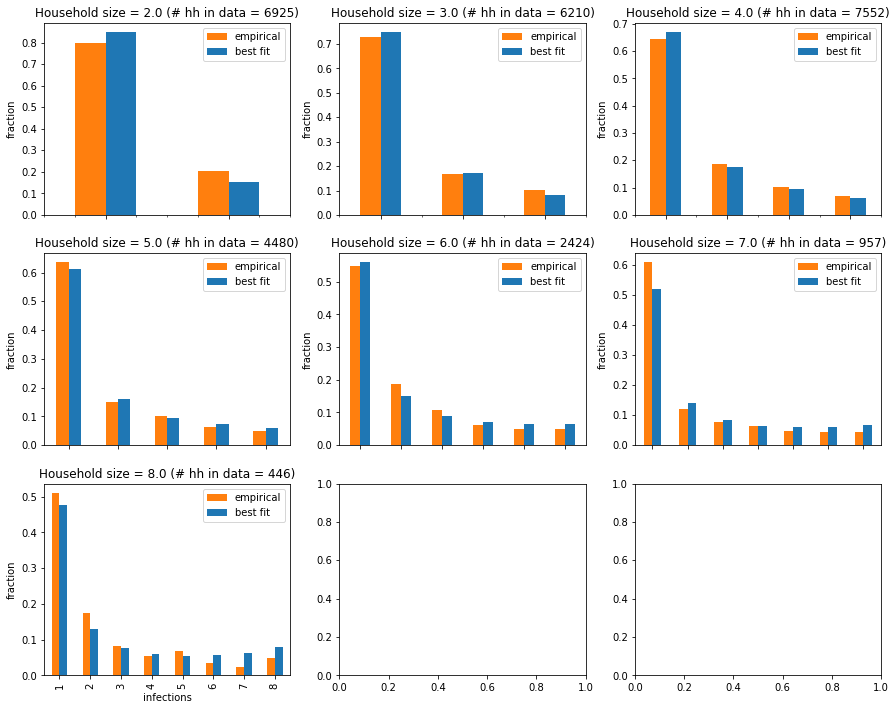

In [12]:
import matplotlib.pyplot as plt
combined_best_and_empirical = pd.concat([empirical_frequencies, best_fit_infections], axis=1)
empirical_sizes = empirical_df.groupby('size').size()
n_sizes = len(empirical_sizes.index.unique())

#which_sizes = [2, 5, 7]
which_sizes = empirical_sizes.index.unique()

n_cols = 3
n_rows = int(np.ceil(len(which_sizes) / n_cols))
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols)
axis_generator = (ax for ax in np.ravel(axes))
cmap = plt.get_cmap("tab10")
color_dict = {'best fit': cmap(0), 'empirical': cmap(1)}
for k,g in combined_best_and_empirical.groupby('size'):
    if k not in which_sizes:
        continue
    try:
        ax = next(axis_generator)
    except StopIteration:
        break
    try:
        title = f"Household size = {k} (# hh in data = {empirical_sizes[k]})"
    except KeyError:
        continue
    g = g.set_index(g.index.droplevel('size'))
    g.plot.bar(
        ax=ax,
        figsize=(5*n_cols,n_rows*4),
        title=title,
        xlabel="infections",
        ylabel="fraction",
        sharex=True,
        color=color_dict
    ),

plt.savefig('output.png', dpi=300, bbox_inches='tight')